In [1]:
import pandas as pd

df = pd.read_csv("../data/Tifin_Test_1/data/sofmattress_train.csv")
df

,sentence,label
0,You guys provide EMI option?,EMI
1,Do you offer Zero Percent EMI payment options?,EMI
2,0% EMI.,EMI
3,EMI,EMI
4,I want in installment,EMI
...,...,...
323,May I please know about the offers,OFFERS
324,Available offers,OFFERS
325,Is offer available,OFFERS
326,Want to know the discount,OFFERS


In [2]:
uq_intents = sorted(df['label'].unique()) + ['UNKNOWN']
uq_intents

['100_NIGHT_TRIAL_OFFER',
 'ABOUT_SOF_MATTRESS',
 'CANCEL_ORDER',
 'CHECK_PINCODE',
 'COD',
 'COMPARISON',
 'DELAY_IN_DELIVERY',
 'DISTRIBUTORS',
 'EMI',
 'ERGO_FEATURES',
 'LEAD_GEN',
 'MATTRESS_COST',
 'OFFERS',
 'ORDER_STATUS',
 'ORTHO_FEATURES',
 'PILLOWS',
 'PRODUCT_VARIANTS',
 'RETURN_EXCHANGE',
 'SIZE_CUSTOMIZATION',
 'WARRANTY',
 'WHAT_SIZE_TO_ORDER',
 'UNKNOWN']

In [3]:
## This doesn't work for the model I am using.

# from pydantic import BaseModel

# class IntentClassification(BaseModel):
#     intent: str

# user_query = "Is offer available"

# completion = client.beta.chat.completions.parse(
#     model="gpt-4o-mini",
#     messages=[
#         {"role": "system", "content": system_message},
#         {
#             "role": "user",
#             "content": user_message.format(
#                 uq_intents_str=uq_intents_str, user_query=user_query
#             ),
#         },
#     ],
#     response_format=IntentClassification,
# )

In [19]:
import json
from dotenv import load_dotenv
load_dotenv("../.env")

from openai import AzureOpenAI
import os

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-07-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)

# uq_intents_str = "\n".join(uq_intents)

output_json_schema = { "intent" : "string" }

system_message = "You are a helpful customer service representative."
user_message = """Your job is to indentify the intent of the customer query.
Pick only one intent from the list of intents provided below.
List of intents:
{uq_intents}

Provide the answer in the JSON format below.
{output_json_schema}

User Query:
{user_query}

Intent:
"""

def get_intent_openai(user_query):
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_message},
            {
                "role": "user",
                "content": user_message.format(
                    uq_intents=uq_intents, user_query=user_query, output_json_schema=output_json_schema
                ),
            },
        ],
        response_format={ "type": "json_object" }
    ) 

    res = json.loads(completion.choices[0].message.content).get("intent") or "UNKNOWN"
    return res

In [20]:
from tqdm.notebook import tqdm
tqdm.pandas()

from concurrent.futures import ThreadPoolExecutor

def process_batch(sentences, max_workers=32):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(get_intent_openai, sentences),
            total=len(sentences),
            desc="Processing intents"
        ))
    return results

df['intent'] = process_batch(df['sentence'].tolist())

# df['intent'] = df['sentence'].progress_apply(get_intent_openai)



Processing intents:   0%|          | 0/328 [00:00<?, ?it/s]

In [21]:
accuracy = (df['intent'] == df['label']).mean()
print(f"Accuracy: {accuracy:.2f}")

# wrong classifications
wrong_df = df[df['intent'] != df['label']].reset_index(drop=True)
wrong_classification_count = wrong_df.shape[0]
print("Number of wrong classifications:", wrong_classification_count)

# wrong where predicted intent is UNKNOWN
unknown_count = (wrong_df['intent'] == 'UNKNOWN').sum()
print(f"Number of unknown intents: {unknown_count}")

# wrong where predicted intent is not UNKNOWN
wrong_count = (wrong_df['intent'] != 'UNKNOWN').sum()
print(f"Number of wrong intents: {wrong_count}")

Accuracy: 0.79
Number of wrong classifications: 69
Number of unknown intents: 43
Number of wrong intents: 26


In [23]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

report = classification_report(df['label'], df['intent'], zero_division=0)
print(report)

                       precision    recall  f1-score   support

100_NIGHT_TRIAL_OFFER       1.00      0.89      0.94        18
   ABOUT_SOF_MATTRESS       0.43      0.91      0.59        11
         CANCEL_ORDER       1.00      1.00      1.00        10
        CHECK_PINCODE       1.00      1.00      1.00        10
                  COD       1.00      1.00      1.00        12
           COMPARISON       0.83      0.91      0.87        11
    DELAY_IN_DELIVERY       0.92      1.00      0.96        11
         DISTRIBUTORS       1.00      0.38      0.55        34
                  EMI       1.00      0.88      0.94        25
        ERGO_FEATURES       1.00      0.73      0.84        11
             LEAD_GEN       0.92      0.57      0.71        21
        MATTRESS_COST       0.95      0.86      0.90        22
               OFFERS       0.83      1.00      0.91        10
         ORDER_STATUS       1.00      0.95      0.98        21
       ORTHO_FEATURES       0.94      0.88      0.91  

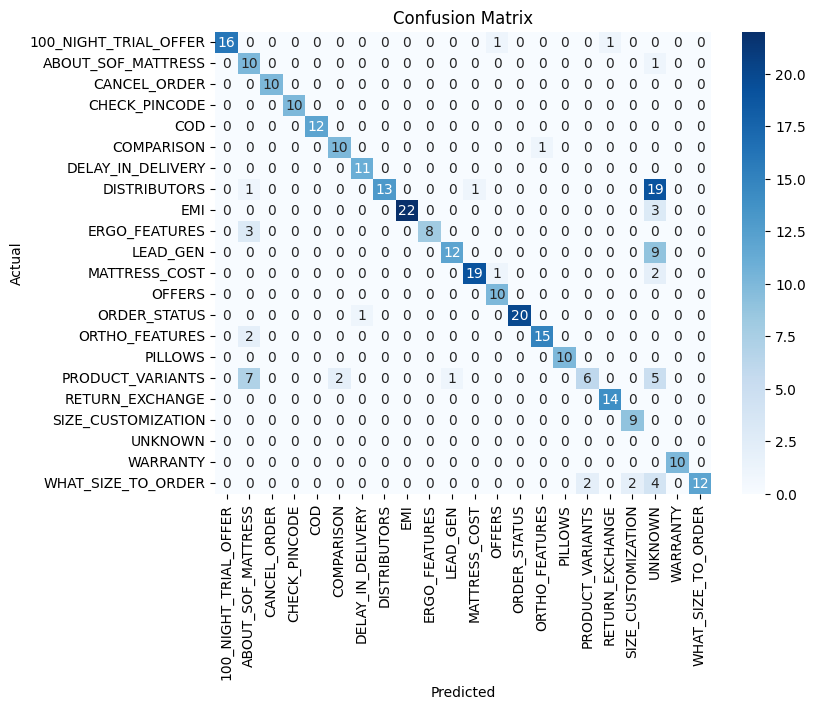

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df['label'], df['intent'])

actual_labels = sorted([*df['label'].unique(), "UNKNOWN"])
predicted_labels = sorted(df['intent'].unique())


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=predicted_labels, yticklabels=actual_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
wrong_df[wrong_df['intent'] != 'UNKNOWN']

,sentence,label,intent
3,What are the key features of the SOF Ortho mat...,ORTHO_FEATURES,ABOUT_SOF_MATTRESS
4,Tell me about SOF Ortho mattress,ORTHO_FEATURES,ABOUT_SOF_MATTRESS
5,Ergo mattress,ERGO_FEATURES,ABOUT_SOF_MATTRESS
6,Tell me about SOF Ergo mattress,ERGO_FEATURES,ABOUT_SOF_MATTRESS
7,What is responsive foam,ERGO_FEATURES,ABOUT_SOF_MATTRESS
8,Is the mattress good for my back,COMPARISON,ORTHO_FEATURES
9,do you provide exchange,100_NIGHT_TRIAL_OFFER,RETURN_EXCHANGE
10,I want to check offers,100_NIGHT_TRIAL_OFFER,OFFERS
14,6*3,WHAT_SIZE_TO_ORDER,SIZE_CUSTOMIZATION
15,What are the sizes available?,WHAT_SIZE_TO_ORDER,PRODUCT_VARIANTS


## Findings after initial runs

1. fix ambigious cases with specific instructions
2. give few shot examples to potentially improve it
3. let the model say "UNKNOWN" if it's not sure? could be helpful to flag cases where the prompt requires changes.